In [1]:
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # 防止使用plot挂掉

In [2]:
# 分类数据集创建方法
def tensorGenCla(num_examples=500, num_inputs=2, num_class=3, deg_dispersion=[4, 2], bias=False):
    cluster_l = torch.empty(num_examples, 1)
    mean_ = deg_dispersion[0]
    std_ = deg_dispersion[1]
    lf = []
    ll = []
    k = mean_ * (num_class - 1) / 2
    
    for i in range(num_class):
        data_tmp = torch.normal(i * mean_ - k, std_, size=(num_examples, num_inputs))
        lf.append(data_tmp)
        labels_tmp = torch.full_like(cluster_l, i)
        ll.append(labels_tmp)
        
    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()
    
    if bias == True:
        features = torch.cat((features, torch.ones(len(features), 1)), 1)
    return features, labels

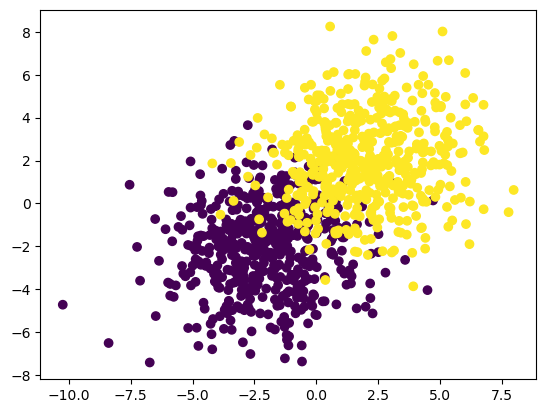

In [3]:
torch.manual_seed(428)
features, labels = tensorGenCla(num_class=2, bias=True)
plt.scatter(features[:, 0], features[:, 1], c=labels)

In [4]:
# 激活函数
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [5]:
# 逻辑回归
def logistic(X, w):
    return sigmoid(torch.mm(X, w))

In [6]:
# 辅助函数
def cal(sigma, p=0.5):
    return ((sigma >= p).float())

In [7]:
# 准确率函数
def accuracy(sigma, y):
    acc_bool = cal(sigma).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return acc

In [8]:
# 定义损失函数
def cross_entropy(sigma, y):
     return -(1/y.numel())*torch.sum((1-y)*torch.log(1-sigma)+y*torch.log(sigma))

In [9]:
# 定义优化方法
def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

In [10]:
# 创建小批量切分函数
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 打乱数据集索引
    l = []
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        l.append([torch.index_select(features, 0, j), torch.index_select(labels, 0, j)])
    return l

In [11]:
# 设置随机数种子
torch.manual_seed(428)    

# 初始化核心参数
batch_size = 10                                # 每一个小批的数量
lr = 0.03                                      # 学习率
num_epochs = 10                                # 训练过程遍历几次数据
w = torch.ones(3, 1, requires_grad = True)     # 随机设置初始权重

# 参与训练的模型方程
net = logistic                                 # 使用逻辑回归方程
loss = cross_entropy                           # 交叉熵损失函数

# 训练过程
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w), y)
        l.backward()
        sgd(w, lr)
    train_acc = accuracy(net(features, w), labels)
    print('epoch %d, accuracy %f' % (epoch + 1, train_acc))

epoch 1, accuracy 0.911000
epoch 2, accuracy 0.911000
epoch 3, accuracy 0.910000
epoch 4, accuracy 0.914000
epoch 5, accuracy 0.917000
epoch 6, accuracy 0.914000
epoch 7, accuracy 0.913000
epoch 8, accuracy 0.914000
epoch 9, accuracy 0.915000
epoch 10, accuracy 0.917000


In [12]:
# 逻辑回归快速实现
batch_size = 10                                # 每一个小批的数量
lr = 0.03                                      # 学习率
num_epochs = 10                                # 训练过程遍历几次数据

In [13]:
torch.manual_seed(428)
features, labels = tensorGenCla(num_class=2)
labels = labels.float()
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size=batch_size, shuffle=True)

In [14]:
# 定义模型
class logisticR(nn.Module):
    def __init__(self, in_features=2, out_features=1):
        super(logisticR, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        out = self.linear(x)
        return out

In [15]:
model = logisticR() # 实例化模型

In [16]:
# 定义损失函数
criterion = nn.BCEWithLogitsLoss()

In [17]:
# 定义优化方法
optimizer = optim.SGD(model.parameters(), lr=lr)

In [19]:
# 模型训练
torch.manual_seed(428)
for epoch in range(num_epochs):
    for X, y in batchData:
        yhat = model.forward(X)
        loss = criterion(yhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [20]:
def acc_zhat(zhat, y):
    sigma = sigmoid(zhat)
    return accuracy(sigma, y)

In [23]:
acc_zhat(model(features), labels)

tensor(0.9170)

In [24]:
# softmax快速实现
batch_size = 10
lr = 0.03
num_epochs = 3

In [25]:
torch.manual_seed(428)
features, labels = tensorGenCla(deg_dispersion=[6, 2])
labels = labels.float()
data = TensorDataset(features, labels)
batchData = DataLoader(data, batch_size=batch_size, shuffle=True)

In [27]:
class softmaxR(nn.Module):
    def __init__(self, in_features=2, out_features=3, bias=False):       # 定义模型结构
        super(softmaxR, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):                                    # 定义模型的正向传播
        out = self.linear(x)             
        return out

# 实例化模型
softmax_model = softmaxR()

In [28]:
# 定义损失函数
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss 会进行softmax处理
# 定义优化方法
optimizer = optim.SGD(softmax_model.parameters(), lr=lr)

In [31]:
# 模型训练
torch.manual_seed(428)
for epoch in range(num_epochs):
    for X, y in batchData:
        zhat = softmax_model.forward(X)
        y = y.flatten().long()
        loss = criterion(zhat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [32]:
# 准确率函数
def m_accuracy(soft_z, y):
    acc_bool = torch.argmax(soft_z, 1).flatten() == y.flatten()
    acc = torch.mean(acc_bool.float())
    return(acc)

In [33]:
# 计算准确率
m_accuracy(F.softmax(softmax_model(features), 1), labels)

tensor(0.9593)